# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill</span>

The project uses [Hopsworks](https://www.hopsworks.ai) as the platform to store features in the **Hopworks Feature Store** and save the trained models in **Hopworks Model Registry**.

## <span style='color:#2656a3'> 🗒️ The notebook is divided into the following sections:
1. Loading the data and process features.
2. Exploratory Data Analysis.
3. Feature Engineering - Moving Window.
4. Connecting to Hopsworks Feature Store.
5. Creating feature groups and uploading them to the feature store.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for electricity prices, weather measures, and the Danish calendar. Then, we proceed to import some of the necessary libraries and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for electricity prices, weather measures, and the danish calendar
from features import electricity_prices, weather_measures, calendar

# We go back into the notebooks folder
%cd pipeline

/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project
/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project/pipeline


In [2]:
# Importing pandas for data handling
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 💽 Loading the Historical Data

The data used comes from the following different sources:

- Hourly electricity prices in Denmark per day on price area DK1 from [Energinet](https://www.energidataservice.dk).  Located in the folder folder `features/electricity_prices`.
- Different meteorological observations based on Aalborg Denmark from [Open Meteo](https://www.open-meteo.com). Located in the folder `features/weather_measures`.
- Weather Forecast based on Aalborg Denmark from [Open Meteo](https://www.open-meteo.com). Located in the folder `features/weather_measures`. (This data is used later to parse new real-time weather data)
- Danish calendar that categorizes dates into types based on whether it is a workday or not. The Calendar is imported from the Python Danish holidays library. Located in the folder `features/calendar`.


### <span style="color:#2656a3;">💸 Electricity Prices per day from Energinet
The first dataset we load is hourly electricity prices per day from Energinet/Dataservice.

In [3]:
# Fetching historical electricity prices for area DK1 from January 1, 2020
# Note: The end date is currently left out to retrieve data up to the day before present date 
# Today is not included in the data as it is not historical data
electricity_price_df = electricity_prices.electricity_prices(
    historical=True, 
    area=["DK1"], 
    start='2020-01-01'
)

In [4]:
# Display the first 5 rows of the electricity dataframe
electricity_price_df.head(5)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh
0,1577836800000,2020-01-01 00:00:00,2020-01-01,0,0.24965
1,1577840400000,2020-01-01 01:00:00,2020-01-01,1,0.23733
2,1577844000000,2020-01-01 02:00:00,2020-01-01,2,0.23583
3,1577847600000,2020-01-01 03:00:00,2020-01-01,3,0.23366
4,1577851200000,2020-01-01 04:00:00,2020-01-01,4,0.23045


In [5]:
# Display the last 5 rows of the electricity dataframe
electricity_price_df.tail(5)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh
38534,1716577200000,2024-05-24 19:00:00,2024-05-24,19,0.97001
38535,1716580800000,2024-05-24 20:00:00,2024-05-24,20,0.93277
38536,1716584400000,2024-05-24 21:00:00,2024-05-24,21,0.86442
38537,1716588000000,2024-05-24 22:00:00,2024-05-24,22,0.81838
38538,1716591600000,2024-05-24 23:00:00,2024-05-24,23,0.74502


In [6]:
# Show the information for the electricity dataframe
electricity_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38539 entries, 0 to 38538
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             38539 non-null  int64         
 1   datetime              38539 non-null  datetime64[ns]
 2   date                  38539 non-null  datetime64[ns]
 3   hour                  38539 non-null  int64         
 4   dk1_spotpricedkk_kwh  38539 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 1.5 MB


### <span style="color:#2656a3;"> 🌤 Weather Measurements from Open Meteo
Next weather measurements from Open Meteo is fetched.

#### <span style="color:#2656a3;"> 🕰️ Historical Weather Measures

In [7]:
# Fetching historical weather measurements from January 1, 2020
# Note: The end date is currently left out to retrieve data up to the day before present date 
# Today is not included in the data as it is not historical data
historical_weather_df = weather_measures.historical_weather_measures(
    historical=True, 
    start = '2020-01-01'
)

In [8]:
# Display the first 5 rows of the weather dataframe
historical_weather_df.head(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
0,1577836800000,2020-01-01 00:00:00,2020-01-01,0,4.9,90.0,0.0,0.0,0.0,1.0,25.0,18.4,33.8
1,1577840400000,2020-01-01 01:00:00,2020-01-01,1,4.9,91.0,0.0,0.0,0.0,0.0,15.0,18.0,35.3
2,1577844000000,2020-01-01 02:00:00,2020-01-01,2,4.8,92.0,0.0,0.0,0.0,2.0,51.0,19.0,36.4
3,1577847600000,2020-01-01 03:00:00,2020-01-01,3,5.1,91.0,0.0,0.0,0.0,2.0,77.0,21.1,41.0
4,1577851200000,2020-01-01 04:00:00,2020-01-01,4,5.4,88.0,0.0,0.0,0.0,3.0,100.0,21.5,42.8


In [9]:
# Display the last 5 rows of the weather dataframe
historical_weather_df.tail(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
38515,1716490800000,2024-05-23 19:00:00,2024-05-23,19,15.9,95.0,2.4,2.4,0.0,61.0,100.0,6.6,19.4
38516,1716494400000,2024-05-23 20:00:00,2024-05-23,20,15.5,95.0,4.6,4.6,0.0,63.0,100.0,4.7,11.5
38517,1716498000000,2024-05-23 21:00:00,2024-05-23,21,15.2,96.0,2.8,2.8,0.0,63.0,100.0,7.4,13.3
38518,1716501600000,2024-05-23 22:00:00,2024-05-23,22,14.9,94.0,0.2,0.2,0.0,51.0,100.0,11.9,22.0
38519,1716505200000,2024-05-23 23:00:00,2024-05-23,23,14.4,95.0,0.0,0.0,0.0,3.0,100.0,9.7,22.0


In [10]:
# Show the information for the weather dataframe
historical_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38520 entries, 0 to 38519
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             38520 non-null  int64         
 1   datetime              38520 non-null  datetime64[ns]
 2   date                  38520 non-null  datetime64[ns]
 3   hour                  38520 non-null  int64         
 4   temperature_2m        38520 non-null  float64       
 5   relative_humidity_2m  38520 non-null  float64       
 6   precipitation         38520 non-null  float64       
 7   rain                  38520 non-null  float64       
 8   snowfall              38520 non-null  float64       
 9   weather_code          38520 non-null  float64       
 10  cloud_cover           38520 non-null  float64       
 11  wind_speed_10m        38520 non-null  float64       
 12  wind_gusts_10m        38520 non-null  float64       
dtypes: datetime64[ns

#### <span style="color:#2656a3;"> 🌈  Forecast Weather Measures
Weather Forecast from Open Meteo is now being fetched. This data is used in the `2_feature_pipeline` to parse in new real-time weather data.

In [11]:
# Fetching weather forecast measures for the next 5 days
forecast_weather_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

In [12]:
# Display the first 5 rows of the weather forecast dataframe
forecast_weather_df.head(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
0,1716595200000,2024-05-25 00:00:00,2024-05-25,0,13.1,88.0,0.0,0.0,0.0,1.0,24.0,2.9,5.0
1,1716598800000,2024-05-25 01:00:00,2024-05-25,1,12.4,85.0,0.0,0.0,0.0,1.0,42.0,5.0,8.3
2,1716602400000,2024-05-25 02:00:00,2024-05-25,2,11.9,84.0,0.0,0.0,0.0,1.0,22.0,4.3,7.6
3,1716606000000,2024-05-25 03:00:00,2024-05-25,3,11.7,85.0,0.0,0.0,0.0,2.0,67.0,4.0,7.9
4,1716609600000,2024-05-25 04:00:00,2024-05-25,4,11.5,85.0,0.0,0.0,0.0,2.0,68.0,3.2,6.1


In [13]:
# Display the last 5 rows of the weather forecast dataframe
forecast_weather_df.tail(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
115,1717009200000,2024-05-29 19:00:00,2024-05-29,19,14.2,92.0,0.0,0.0,0.0,3.0,96.0,10.8,26.6
116,1717012800000,2024-05-29 20:00:00,2024-05-29,20,13.8,93.0,0.0,0.0,0.0,3.0,91.0,9.7,22.3
117,1717016400000,2024-05-29 21:00:00,2024-05-29,21,13.5,94.0,0.0,0.0,0.0,3.0,87.0,8.6,18.4
118,1717020000000,2024-05-29 22:00:00,2024-05-29,22,13.2,95.0,0.0,0.0,0.0,2.0,84.0,7.3,16.2
119,1717023600000,2024-05-29 23:00:00,2024-05-29,23,13.0,95.0,0.0,0.0,0.0,2.0,80.0,6.5,14.0


In [14]:
# Show the information for the weather weather forecast dataframe
forecast_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             120 non-null    int64         
 1   datetime              120 non-null    datetime64[ns]
 2   date                  120 non-null    datetime64[ns]
 3   hour                  120 non-null    int64         
 4   temperature_2m        120 non-null    float64       
 5   relative_humidity_2m  120 non-null    float64       
 6   precipitation         120 non-null    float64       
 7   rain                  120 non-null    float64       
 8   snowfall              120 non-null    float64       
 9   weather_code          120 non-null    float64       
 10  cloud_cover           120 non-null    float64       
 11  wind_speed_10m        120 non-null    float64       
 12  wind_gusts_10m        120 non-null    float64       
dtypes: datetime64[ns](2)

### <span style="color:#2656a3;"> 🗓️ Calendar of Danish Workdays and Holidays 
Lastly, the calendar data is being loaded in. The calendar data includes a `workday` attribute indicating whether the date is a workday or not. This column has been encoded from categorical variables into numerical form in the folder `features/calendar`. `1` indicating a workday and `0` indicating a non-workday.  

In [15]:
# Defining start and end year for the calendar data
# The end date is dynamic and will be the last day of the next year
start='2020-01-01'
end=pd.Timestamp(pd.Timestamp.now().year + 1, 12, 31).date()

# Print the start and end date
print(f"Fetching historical calendar from {start} to {end}")

Fetching historical calendar from 2020-01-01 to 2025-12-31


In [16]:
# Fetching the Danish calendar from January 1, 2020 to end of December next year. Frequency is set to daily
danish_calendar_df = calendar.calendar_denmark(
    freq='D',
    start=start, 
    end=end
)

In [17]:
# Display the first 5 rows of the calendar dataframe
danish_calendar_df.head(5)

,datetime,date,hour,dayofweek,day,month,year,timestamp,workday
0,2020-01-01,2020-01-01,0,2,1,1,2020,1577836800000,0
1,2020-01-02,2020-01-02,0,3,2,1,2020,1577923200000,1
2,2020-01-03,2020-01-03,0,4,3,1,2020,1578009600000,1
3,2020-01-04,2020-01-04,0,5,4,1,2020,1578096000000,0
4,2020-01-05,2020-01-05,0,6,5,1,2020,1578182400000,0


In [18]:
# Display the last 5 rows of the calendar dataframe
danish_calendar_df.tail(5)

,datetime,date,hour,dayofweek,day,month,year,timestamp,workday
2187,2025-12-27,2025-12-27,0,5,27,12,2025,1766793600000,0
2188,2025-12-28,2025-12-28,0,6,28,12,2025,1766880000000,0
2189,2025-12-29,2025-12-29,0,0,29,12,2025,1766966400000,1
2190,2025-12-30,2025-12-30,0,1,30,12,2025,1767052800000,1
2191,2025-12-31,2025-12-31,0,2,31,12,2025,1767139200000,1


In [19]:
# Show the information for the calendar dataframe
danish_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2192 entries, 0 to 2191
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   2192 non-null   datetime64[ns]
 1   date       2192 non-null   datetime64[ns]
 2   hour       2192 non-null   int64         
 3   dayofweek  2192 non-null   int64         
 4   day        2192 non-null   int64         
 5   month      2192 non-null   int64         
 6   year       2192 non-null   int64         
 7   timestamp  2192 non-null   int64         
 8   workday    2192 non-null   int64         
dtypes: datetime64[ns](2), int64(7)
memory usage: 171.2 KB


## <span style="color:#2656a3;"> 🛠️ Feature Engineering </span>

Feature engineering is a crucial step in the data preprocessing pipeline, where we want to create new informative features to enhance model performance. One powerful feature engineering technique for time series data involves the use of moving windows, which involves calculating statistical measures over a rolling window of data points.

The calculation involves taking the average, sum, or another statistic of a fixed-size window that moves incrementally through the data series. Used for time series analysis to smooth out short-term fluctuations and highlight longer-term trends or cycles. As the window moves forward, it drops the oldest value and includes the next new value.

This feature engineering has been done in a function located in the folder folder `features/electricity_prices`.

In [20]:
electricity_price_window_df = electricity_prices.electricity_prices_window(
    historical=True,
    area=["DK1"],
    start='2020-01-01'
)

In [21]:
# Display the first 5 rows of the dataframe
electricity_price_window_df.head(5)

,timestamp,datetime,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean
0,1577836800000,2020-01-01 00:00:00,0.249650,0.249650,0.249650,0.249650,0.249650,0.249650
1,1577840400000,2020-01-01 01:00:00,0.243490,0.243490,0.243490,0.243490,0.243490,0.243490
2,1577844000000,2020-01-01 02:00:00,0.240937,0.240937,0.240937,0.240937,0.240937,0.240937
3,1577847600000,2020-01-01 03:00:00,0.239118,0.239118,0.239118,0.239118,0.239118,0.239118
4,1577851200000,2020-01-01 04:00:00,0.237384,0.237384,0.237384,0.237384,0.237384,0.237384


In [22]:
# Display the last 5 rows of the dataframe
electricity_price_window_df.tail(5)

,timestamp,datetime,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean
38539,1716577200000,2024-05-24 19:00:00,0.468246,0.342053,0.396973,0.438114,0.419202,0.432230
38540,1716580800000,2024-05-24 20:00:00,0.472330,0.341279,0.396845,0.438673,0.419411,0.432406
38541,1716584400000,2024-05-24 21:00:00,0.476026,0.340914,0.396911,0.439182,0.419611,0.432570
38542,1716588000000,2024-05-24 22:00:00,0.479519,0.341021,0.397099,0.439654,0.419799,0.432717
38543,1716591600000,2024-05-24 23:00:00,0.482602,0.341233,0.397228,0.440067,0.419965,0.432841


In [23]:
# Show the information for the dataframe
electricity_price_window_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38544 entries, 0 to 38543
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      38544 non-null  int64         
 1   datetime       38544 non-null  datetime64[ns]
 2   prev_1w_mean   38544 non-null  float64       
 3   prev_2w_mean   38544 non-null  float64       
 4   prev_4w_mean   38544 non-null  float64       
 5   prev_6w_mean   38544 non-null  float64       
 6   prev_8w_mean   38544 non-null  float64       
 7   prev_12w_mean  38544 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 2.6 MB


In the below we will show the steps for the performed engineering

In [24]:
# Check if there are any missing values in the electricity dataframe
electricity_price_df[electricity_price_df['dk1_spotpricedkk_kwh'].isna()]

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh


In [25]:
# Defining start and end year for the calendar data
# The end date is dynamic and will be the present day and 7 days ahead
start='2020-01-01'
end=datetime.now().date() + timedelta(days=7)

# Print the start and end date
print(f"Fetching historical calendar from {start} to {end}")

Fetching historical calendar from 2020-01-01 to 2024-06-01


In [26]:
# Fetching the Danish calendar from January 1, 2020 to the present day plus 7 days. Frequency is set to hourly
danish_calendar_hours_df = calendar.calendar_denmark(
    freq='H',
    start=start, 
    end=end
)

In [27]:
# Merging the electricity and calendar dataframes
merge_data = pd.merge(electricity_price_df, danish_calendar_hours_df, how='right', left_on='timestamp', right_on='timestamp')

# Drop and rename columns
merge_data = merge_data.drop(columns=['date_x', 'datetime_x', 'hour_x'])
merge_data = merge_data.rename(columns={'date_y': 'date', 
                                        'datetime_y': 'datetime', 
                                        'hour_y': 'hour'})

In [28]:
# Checking if there are any missing values in the merged dataframe
merge_data[merge_data['dk1_spotpricedkk_kwh'].isna()]

,timestamp,dk1_spotpricedkk_kwh,datetime,date,hour,dayofweek,day,month,year,workday
2114,1585447200000,NaN,2020-03-29 02:00:00,2020-03-29,2,6,29,3,2020,0
10850,1616896800000,NaN,2021-03-28 02:00:00,2021-03-28,2,6,28,3,2021,0
19586,1648346400000,NaN,2022-03-27 02:00:00,2022-03-27,2,6,27,3,2022,0
28322,1679796000000,NaN,2023-03-26 02:00:00,2023-03-26,2,6,26,3,2023,0
37226,1711850400000,NaN,2024-03-31 02:00:00,2024-03-31,2,6,31,3,2024,0
...,...,...,...,...,...,...,...,...,...,...
38731,1717268400000,NaN,2024-06-01 19:00:00,2024-06-01,19,5,1,6,2024,0
38732,1717272000000,NaN,2024-06-01 20:00:00,2024-06-01,20,5,1,6,2024,0
38733,1717275600000,NaN,2024-06-01 21:00:00,2024-06-01,21,5,1,6,2024,0
38734,1717279200000,NaN,2024-06-01 22:00:00,2024-06-01,22,5,1,6,2024,0


We can see in the above dataframe that there are some missing historical `dk1_spotpricedkk_kwh` values when we merge on hour. Therefore we want to fill in the gap with the `dk1_spotpricedkk_kwh` of the previous hour. We only want to adjust historical data, therefore, we set `['datetime'].dt.date < today`.

In [29]:
# First we make a copy of the merged data for versioning. Ensures that the original merged data remains unchanged
merge_data_for_rolling_window = merge_data.copy()

# Get today's date (only the date part, without time)
today = datetime.today().date()

# Create a boolean mask where the 'datetime' column's date part is before today
mask = merge_data_for_rolling_window['datetime'].dt.date < today

# Fill NaN values in the 'dk1_spotpricedkk_kwh' column with the previous row's value
# Only fill NaNs for rows where the date is before today (using the mask)
merge_data_for_rolling_window.loc[mask, 'dk1_spotpricedkk_kwh'] = merge_data_for_rolling_window['dk1_spotpricedkk_kwh'].ffill()

In [30]:
# Checking if there are any missing values in the new merged dataframe
merge_data_for_rolling_window[merge_data_for_rolling_window['dk1_spotpricedkk_kwh'].isna()]

,timestamp,dk1_spotpricedkk_kwh,datetime,date,hour,dayofweek,day,month,year,workday
38544,1716595200000,NaN,2024-05-25 00:00:00,2024-05-25,0,5,25,5,2024,0
38545,1716598800000,NaN,2024-05-25 01:00:00,2024-05-25,1,5,25,5,2024,0
38546,1716602400000,NaN,2024-05-25 02:00:00,2024-05-25,2,5,25,5,2024,0
38547,1716606000000,NaN,2024-05-25 03:00:00,2024-05-25,3,5,25,5,2024,0
38548,1716609600000,NaN,2024-05-25 04:00:00,2024-05-25,4,5,25,5,2024,0
...,...,...,...,...,...,...,...,...,...,...
38731,1717268400000,NaN,2024-06-01 19:00:00,2024-06-01,19,5,1,6,2024,0
38732,1717272000000,NaN,2024-06-01 20:00:00,2024-06-01,20,5,1,6,2024,0
38733,1717275600000,NaN,2024-06-01 21:00:00,2024-06-01,21,5,1,6,2024,0
38734,1717279200000,NaN,2024-06-01 22:00:00,2024-06-01,22,5,1,6,2024,0


Now we only have missing `dk1_spotpricedkk_kwh` values for non_historical data.

In [31]:
# Defining a copy of the combined data to avoid modifying the original dataframe
electricity_price_rolling_window = merge_data_for_rolling_window.copy()

# Adding a column with the mean for the previous 1 week
electricity_price_rolling_window['prev_1w_mean'] = electricity_price_rolling_window['dk1_spotpricedkk_kwh'].rolling(window=24*(1*7), min_periods=1).mean()

# Adding a column with the mean for the previous 2 weeks
electricity_price_rolling_window['prev_2w_mean'] = electricity_price_rolling_window['dk1_spotpricedkk_kwh'].rolling(window=24*(2*7), min_periods=1).mean()

# Adding a column with the mean for the previous 4 weeks
electricity_price_rolling_window['prev_4w_mean'] = electricity_price_rolling_window['dk1_spotpricedkk_kwh'].rolling(window=24*(4*7), min_periods=1).mean()

# Adding a column with the mean for the previous 6 weeks
electricity_price_rolling_window['prev_6w_mean'] = electricity_price_rolling_window['dk1_spotpricedkk_kwh'].rolling(window=24*(6*7), min_periods=1).mean()

# Adding a column with the mean for the previous 8 weeks
electricity_price_rolling_window['prev_8w_mean'] = electricity_price_rolling_window['dk1_spotpricedkk_kwh'].rolling(window=24*(8*7), min_periods=1).mean()

# Adding a column with the mean for the previous 12 weeks
electricity_price_rolling_window['prev_12w_mean'] = electricity_price_rolling_window['dk1_spotpricedkk_kwh'].rolling(window=24*(12*7), min_periods=1).mean()

# Only keep the columns 'timestamp', 'prev_1w_mean', 'prev_2w_mean', and 'prev_4w_mean'
electricity_price_rolling_window = electricity_price_rolling_window[['timestamp', 'datetime', 'prev_1w_mean', 'prev_2w_mean', 'prev_4w_mean', 'prev_6w_mean', 'prev_8w_mean', 'prev_12w_mean']]

# Display the DataFrame with the new columns of rolling means
electricity_price_rolling_window

,timestamp,datetime,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean
0,1577836800000,2020-01-01 00:00:00,0.249650,0.249650,0.249650,0.249650,0.249650,0.249650
1,1577840400000,2020-01-01 01:00:00,0.243490,0.243490,0.243490,0.243490,0.243490,0.243490
2,1577844000000,2020-01-01 02:00:00,0.240937,0.240937,0.240937,0.240937,0.240937,0.240937
3,1577847600000,2020-01-01 03:00:00,0.239118,0.239118,0.239118,0.239118,0.239118,0.239118
4,1577851200000,2020-01-01 04:00:00,0.237384,0.237384,0.237384,0.237384,0.237384,0.237384
...,...,...,...,...,...,...,...,...
38731,1717268400000,2024-06-01 19:00:00,NaN,0.515100,0.411789,0.442645,0.422362,0.426689
38732,1717272000000,2024-06-01 20:00:00,NaN,0.512304,0.410551,0.442302,0.422425,0.426689
38733,1717275600000,2024-06-01 21:00:00,NaN,0.509967,0.409645,0.442019,0.422509,0.426690
38734,1717279200000,2024-06-01 22:00:00,NaN,0.508518,0.409097,0.441773,0.422619,0.426697


## <span style="color:#2656a3;"> 📊 Exploratory Data Analysis
Exploratory Data Analysis is performed aimed at understanding the characteristics and underlying patterns within the data.

### <span style="color:#2656a3;"> 💽 Load the Data for EDA purpose
We start by combining the historical electricity prices, calendar, and historical weather dataframes so we can create a correlation matrix on all the variables in the datasets.

In [32]:
# Merging the electricity and calendar dataframes
combined_df = pd.merge(electricity_price_df, danish_calendar_df, how='inner', left_on='date', right_on='date')

# Dropping and renameing columns
combined_df.drop(columns=['datetime_y', 'hour_y', 'timestamp_y'], inplace=True)
combined_df.rename(columns={
    'timestamp_x': 'timestamp', 
    'datetime_x': 'datetime', 
    'hour_x': 'hour'
}, inplace=True)

In [33]:
# Merging the electricity_df and calendar_df with the historical weather data
combined_df = pd.merge(combined_df, historical_weather_df, how='inner', left_on='timestamp', right_on='timestamp')

# Dropping and renameing columns
combined_df.drop(columns=['datetime_y', 'date_y', 'hour_y'], inplace=True)
combined_df.rename(columns={
    'datetime_x': 'datetime', 
    'date_x': 'date', 
    'hour_x': 'hour', 
}, inplace=True)

In [34]:
# Merging the electricity_df and calendar_df and historical_weather_df with the electricity window 
combined_df = pd.merge(combined_df, electricity_price_window_df, how='inner', left_on='timestamp', right_on='timestamp')

# Dropping and renameing columns
combined_df.drop(columns=['datetime_y'], inplace=True)
combined_df.rename(columns={
    'datetime_x': 'datetime', 
}, inplace=True)

In [35]:
# Display the first 5 rows of the cleaned dataframe
combined_df.head(5)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,dayofweek,day,month,year,workday,...,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean
0,1577836800000,2020-01-01 00:00:00,2020-01-01,0,0.24965,2,1,1,2020,0,...,1.0,25.0,18.4,33.8,0.249650,0.249650,0.249650,0.249650,0.249650,0.249650
1,1577840400000,2020-01-01 01:00:00,2020-01-01,1,0.23733,2,1,1,2020,0,...,0.0,15.0,18.0,35.3,0.243490,0.243490,0.243490,0.243490,0.243490,0.243490
2,1577844000000,2020-01-01 02:00:00,2020-01-01,2,0.23583,2,1,1,2020,0,...,2.0,51.0,19.0,36.4,0.240937,0.240937,0.240937,0.240937,0.240937,0.240937
3,1577847600000,2020-01-01 03:00:00,2020-01-01,3,0.23366,2,1,1,2020,0,...,2.0,77.0,21.1,41.0,0.239118,0.239118,0.239118,0.239118,0.239118,0.239118
4,1577851200000,2020-01-01 04:00:00,2020-01-01,4,0.23045,2,1,1,2020,0,...,3.0,100.0,21.5,42.8,0.237384,0.237384,0.237384,0.237384,0.237384,0.237384


### <span style="color:#2656a3;"> 📊 Visualization of the data to understand patterns in the data

#### <span style="color:#2656a3;"> 🪙 Plot the distribution of key variables for electricity price
Now we want to deep dive into key variables for electricity price. First we sort the combined_df on `timestamp` so we have the right order for this time series.

In [36]:
# Sorting the dataframe by timestamp 
combined_df.sort_values(by='timestamp', ascending=True, inplace=True)

# Resetting the index of the dataframe
combined_df = combined_df.reset_index(drop=True)

Time series line plot provides a visual representation of how electricity prices in the DK1 area change over time, highlighting trends, volatility, and potential anomalies.

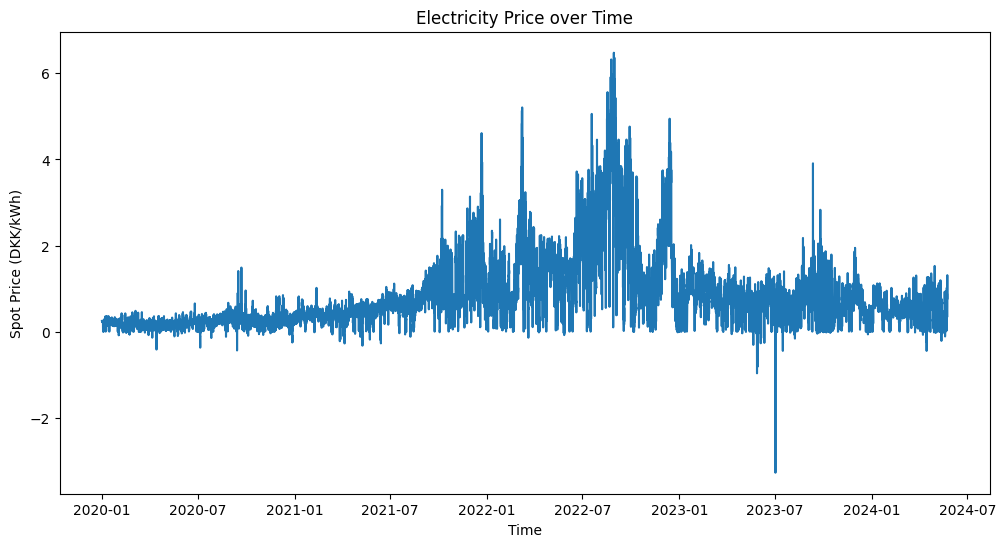

In [37]:
# Create a time series plot of the electricity prices
plt.figure(figsize=(12, 6))
plt.plot(combined_df['datetime'], combined_df['dk1_spotpricedkk_kwh'])

# Adding labels and title
plt.title('Electricity Price over Time')
plt.xlabel('Time')
plt.ylabel('Spot Price (DKK/kWh)')

# Show the plot
plt.show()

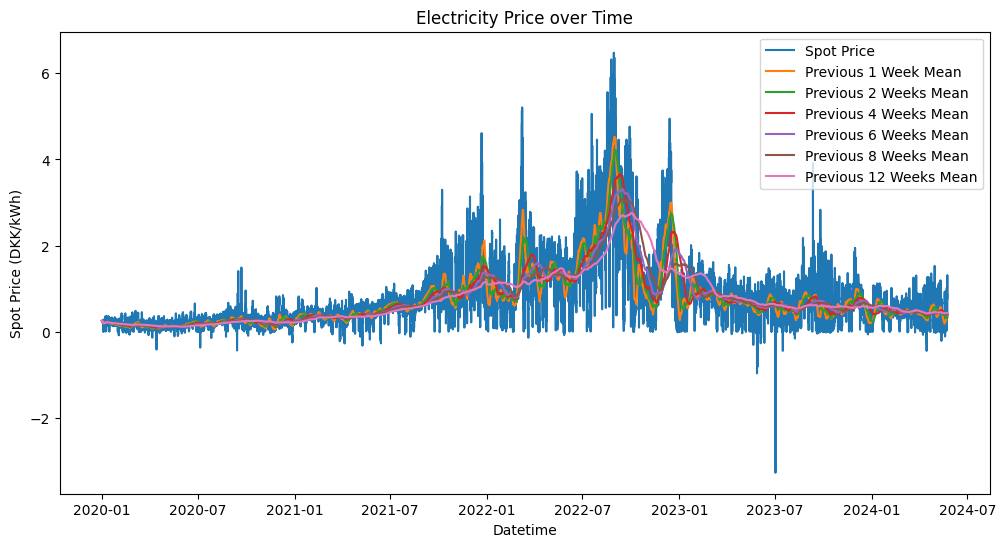

In [38]:
# Create a time series plot of the electricity prices
plt.figure(figsize=(12, 6))
plt.plot(combined_df['datetime'], combined_df['dk1_spotpricedkk_kwh'], label='Spot Price')
plt.plot(combined_df['datetime'], combined_df['prev_1w_mean'], label='Previous 1 Week Mean')
plt.plot(combined_df['datetime'], combined_df['prev_2w_mean'], label='Previous 2 Weeks Mean')
plt.plot(combined_df['datetime'], combined_df['prev_4w_mean'], label='Previous 4 Weeks Mean')
plt.plot(combined_df['datetime'], combined_df['prev_6w_mean'], label='Previous 6 Weeks Mean')
plt.plot(combined_df['datetime'], combined_df['prev_8w_mean'], label='Previous 8 Weeks Mean')
plt.plot(combined_df['datetime'], combined_df['prev_12w_mean'], label='Previous 12 Weeks Mean')

# Adding labels and title
plt.title('Electricity Price over Time')
plt.xlabel('Datetime')
plt.ylabel('Spot Price (DKK/kWh)')
plt.legend(loc='upper right')

# Show the plot
plt.show()

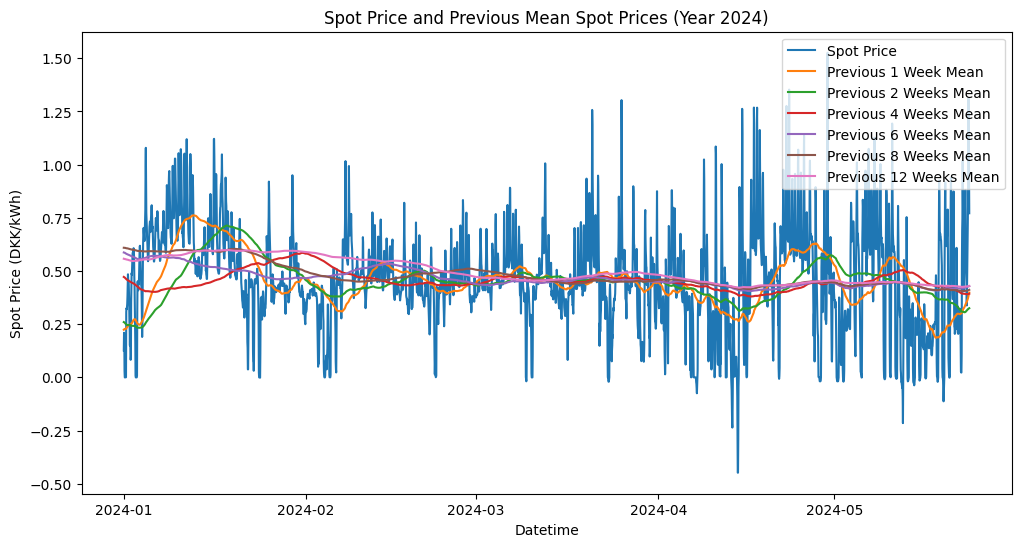

In [39]:
# Filter data for the year 2024
combined_df_2024 = combined_df[combined_df['year'] == 2024]

# Plot the spot price and previous mean spot prices for the year 2024
plt.figure(figsize=(12, 6))
plt.plot(combined_df_2024['datetime'], combined_df_2024['dk1_spotpricedkk_kwh'], label='Spot Price')
plt.plot(combined_df_2024['datetime'], combined_df_2024['prev_1w_mean'], label='Previous 1 Week Mean')
plt.plot(combined_df_2024['datetime'], combined_df_2024['prev_2w_mean'], label='Previous 2 Weeks Mean')
plt.plot(combined_df_2024['datetime'], combined_df_2024['prev_4w_mean'], label='Previous 4 Weeks Mean')
plt.plot(combined_df_2024['datetime'], combined_df_2024['prev_6w_mean'], label='Previous 6 Weeks Mean')
plt.plot(combined_df_2024['datetime'], combined_df_2024['prev_8w_mean'], label='Previous 8 Weeks Mean')
plt.plot(combined_df_2024['datetime'], combined_df_2024['prev_12w_mean'], label='Previous 12 Weeks Mean')

# Adding labels and title
plt.title('Spot Price and Previous Mean Spot Prices (Year 2024)')
plt.xlabel('Datetime')
plt.ylabel('Spot Price (DKK/kWh)')
plt.legend(loc='upper right')

# Show the plot
plt.show()

A plot over electricity spot by different days of the week helps to understand how the average electricity spot prices vary across different days of the week, providing a clear comparison and highlighting any significant trends or anomalies.

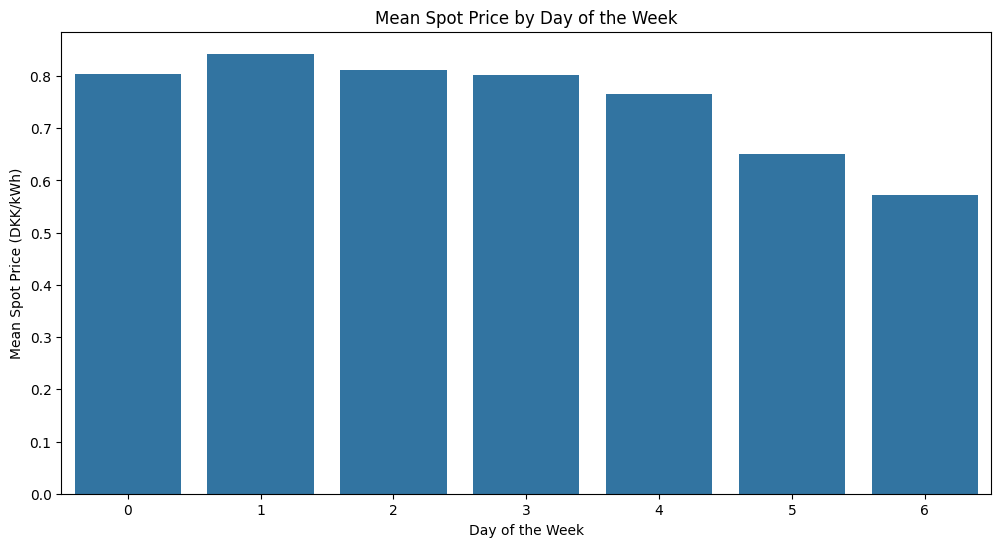

In [40]:
# Calculate mean spot price for each day of the week
mean_spotprice_by_dayofweek = combined_df.groupby('dayofweek')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by day of the week as a histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='dayofweek', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_dayofweek)

# Adding labels and title
plt.title('Mean Spot Price by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Spot Price (DKK/kWh)')

# Show the plot
plt.show()

We can also look into if a day is a workday or non-workday

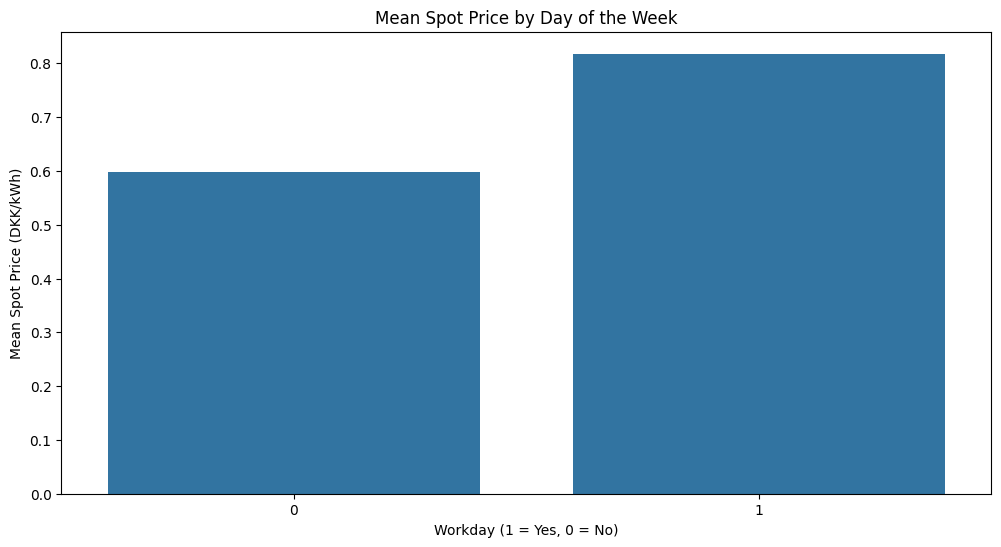

In [41]:
# Calculate mean spot price for each day of the week
mean_spotprice_by_workday = combined_df.groupby('workday')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by day of the week as a histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='workday', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_workday)

# Adding labels and title
plt.title('Mean Spot Price by Day of the Week')
plt.xlabel('Workday (1 = Yes, 0 = No)')
plt.ylabel('Mean Spot Price (DKK/kWh)')

# Show the plot
plt.show()

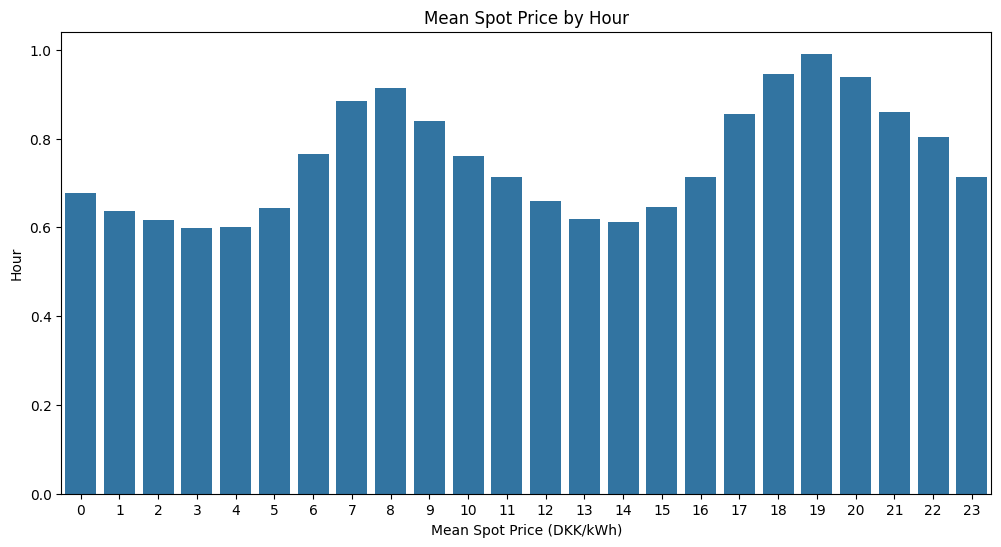

In [42]:
# Calculate mean spot price for each hour of the day
mean_spotprice_by_hour = combined_df.groupby('hour')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by hour of the day as a horizontally oriented histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_hour)

# Adding labels and title
plt.title('Mean Spot Price by Hour')
plt.xlabel('Mean Spot Price (DKK/kWh)')
plt.ylabel('Hour')

# Show the plot
plt.show()

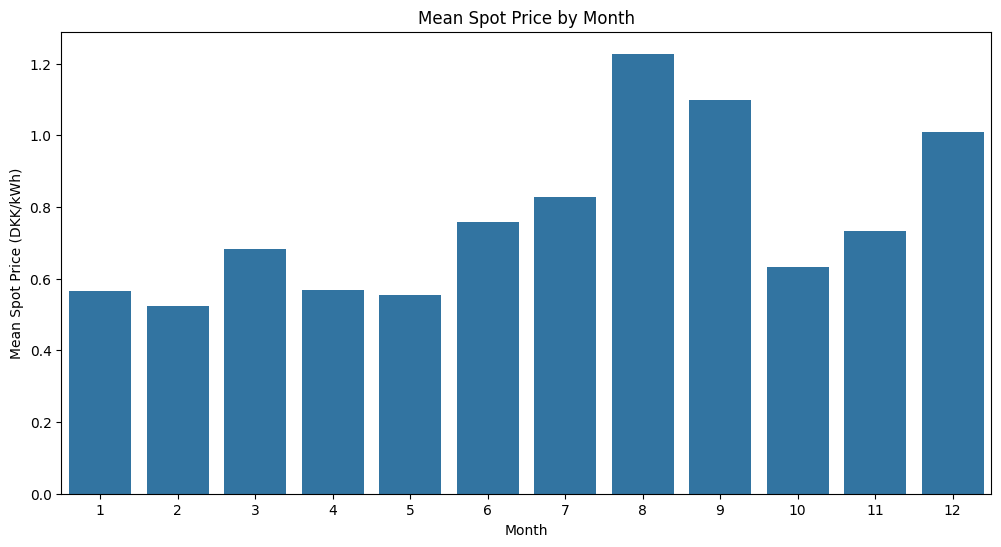

In [43]:
# Calculate mean spot price for each month
mean_spotprice_by_month = combined_df.groupby('month')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by month as a histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_month)

# Adding labels and title
plt.title('Mean Spot Price by Month')
plt.xlabel('Month')
plt.ylabel('Mean Spot Price (DKK/kWh)')

# Show the plot
plt.show()

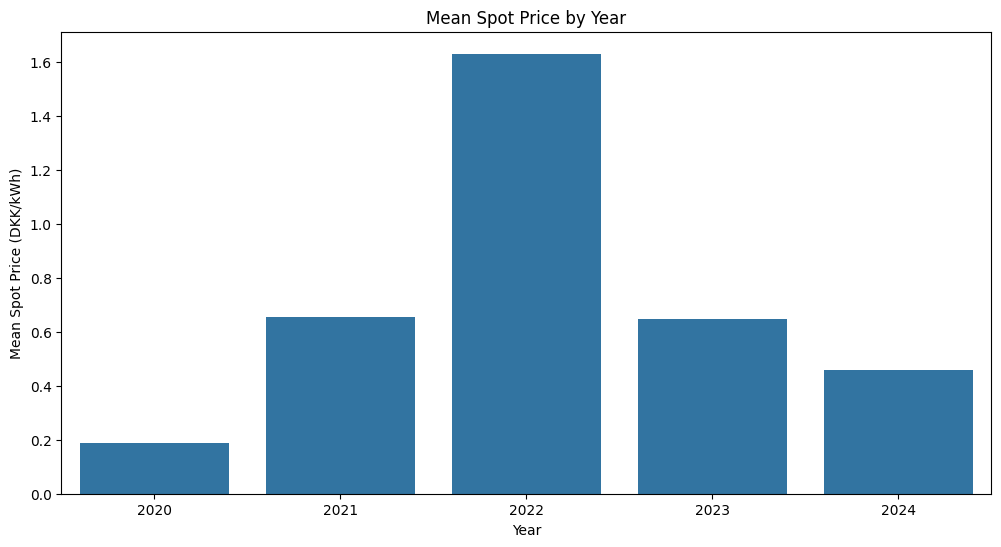

In [44]:
# Calculate mean spot price for each month
mean_spotprice_by_year = combined_df.groupby('year')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by month as a histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_year)

# Adding labels and title
plt.title('Mean Spot Price by Year')
plt.xlabel('Year')
plt.ylabel('Mean Spot Price (DKK/kWh)')

# Show the plot
plt.show()

Histogram with KDE (kernel density estimate) plot provides a comprehensive view of the distribution of electricity prices in the dataset. It highlights the central tendency, spread, skewness, and potential outliers.

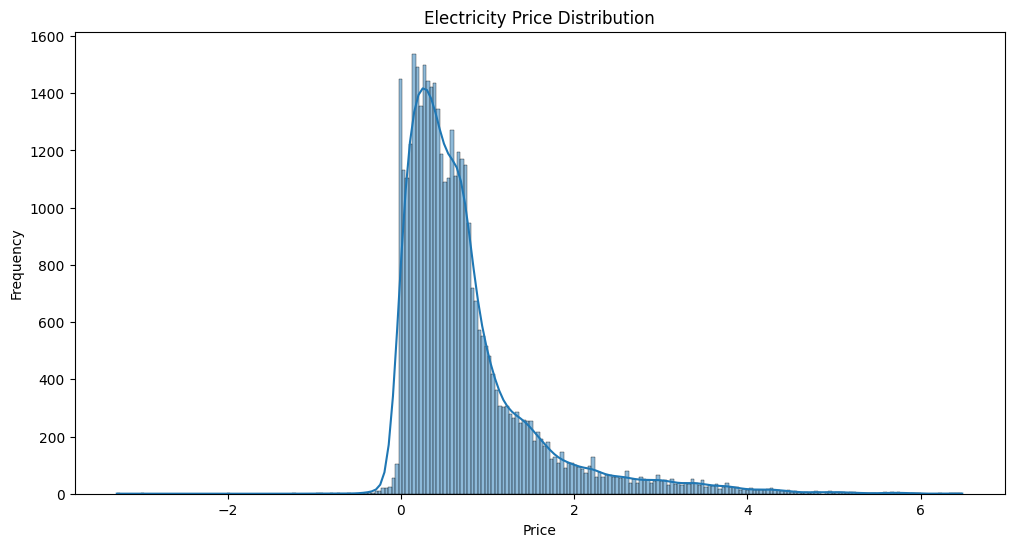

In [45]:
# Create a histogram with a KDE plot
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['dk1_spotpricedkk_kwh'], kde=True)

# Add labels and title
plt.title('Electricity Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Show the plot
plt.show()

#### <span style="color:#2656a3;"> ☀️ Weather Data
Time series line plots for the `historical_weather` dataframe to understanding some of the temporal dynamics of the data.

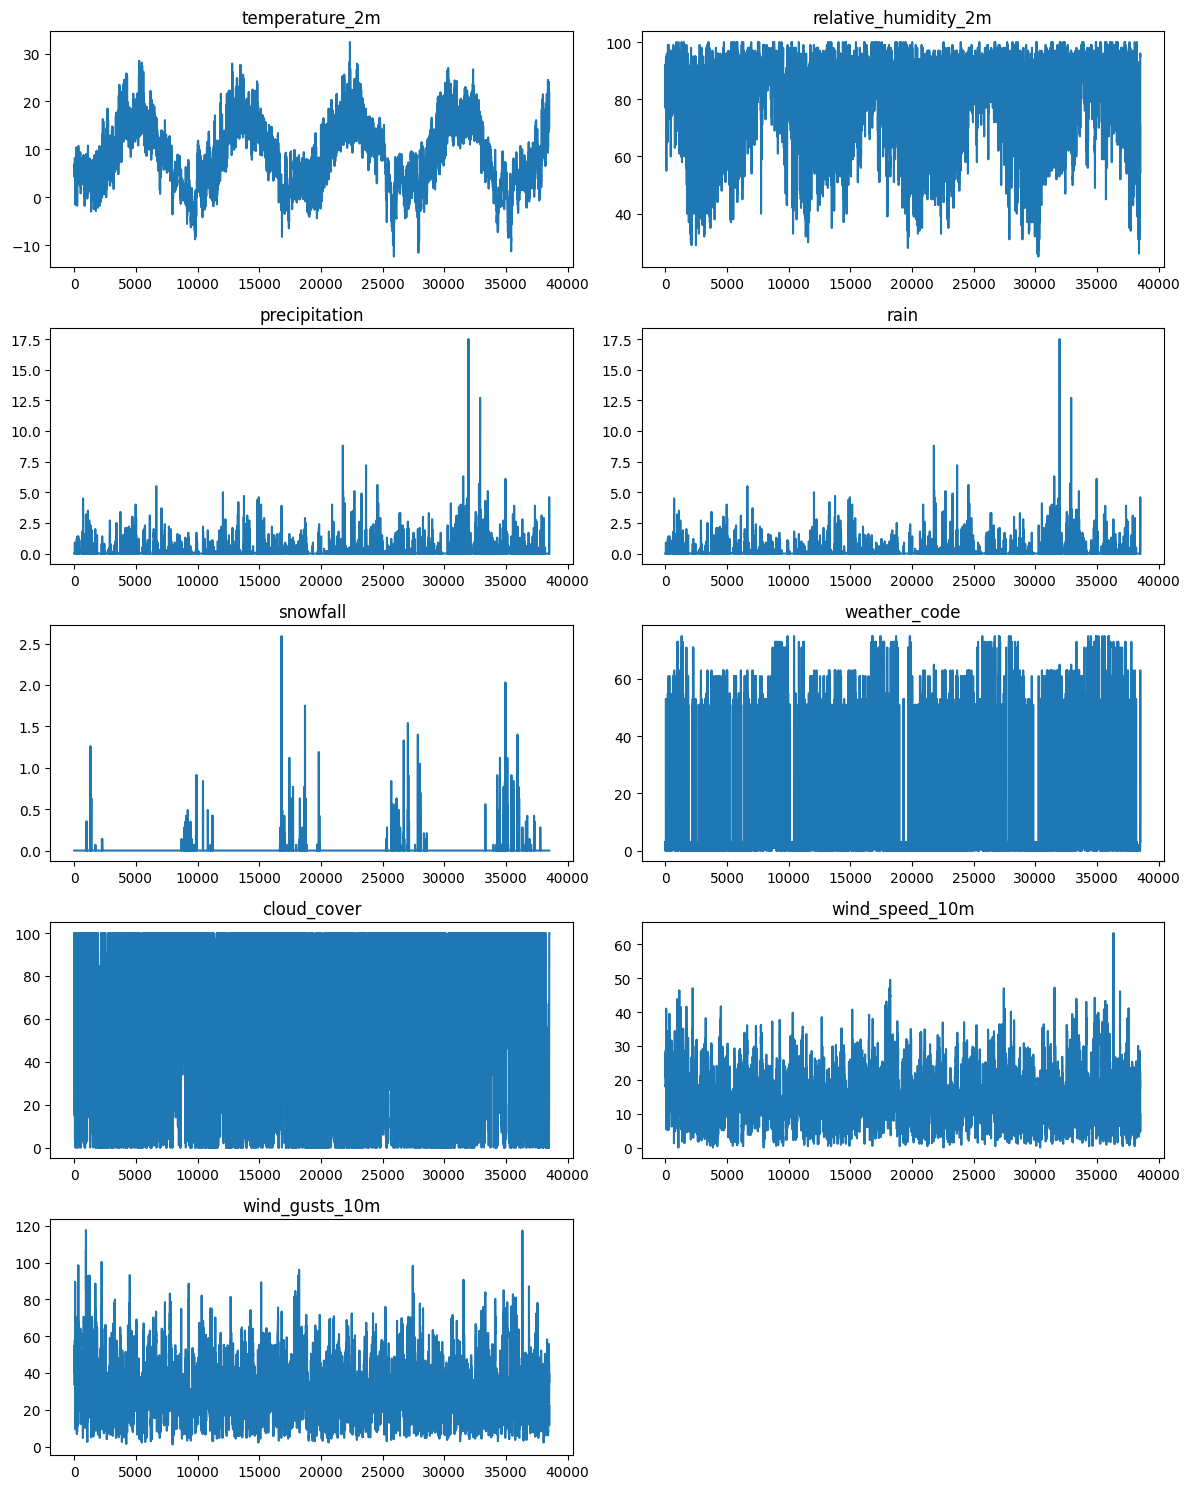

In [46]:
# Converting the DataFrame to a NumPy array for easier slicing
values = historical_weather_df.values

# Specifying columns to plot
groups = [4, 5, 6, 7, 8, 9, 10, 11, 12]

# Calculate the number of columns and rows needed for the subplot grid
n_cols = 2
n_rows = (len(groups) + 1) // n_cols

# Set the size of the entire figure
plt.figure(figsize=(12, n_rows * 3))

# Loop through each group index and create a subplot for each column
for i, group in enumerate(groups):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(values[:, group])
    plt.title(historical_weather_df.columns[group], y=1, loc='center')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Histogram with KDE (kernel density estimate) plot provides a comprehensive view of the distribution of weather temperature in the dataset. It highlights the central tendency, spread, skewness, and potential outliers.

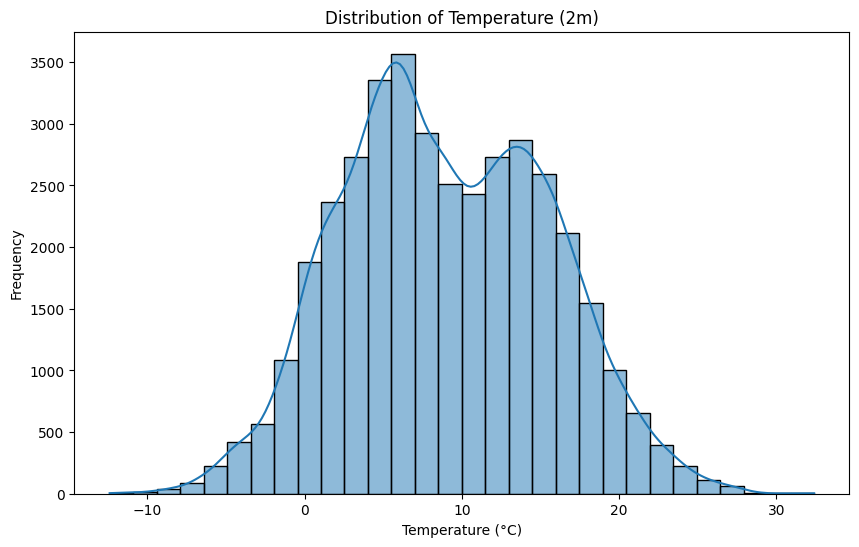

In [47]:
# Distribution of Temperature
plt.figure(figsize=(10, 6))
sns.histplot(historical_weather_df['temperature_2m'], bins=30, kde=True)

# Add labels and title
plt.title('Distribution of Temperature (2m)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

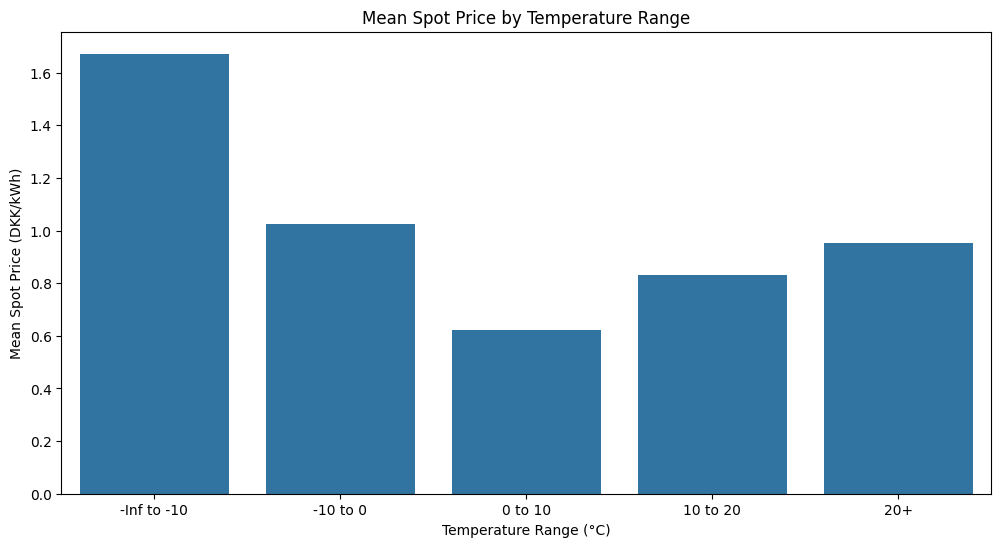

In [48]:
# Define temperature ranges
temperature_ranges = [(-np.inf, -10), (-10, 0), (0, 10), (10, 20), (20, np.inf)]
temperature_labels = ['-Inf to -10', '-10 to 0', '0 to 10', '10 to 20', '20+']

# Categorize temperature data into ranges
combined_df['temperature_range'] = pd.cut(combined_df['temperature_2m'], bins=[range[0] for range in temperature_ranges] + [np.inf], labels=temperature_labels)

# Calculate mean spot price for each temperature range
mean_spotprice_by_temperature = combined_df.groupby('temperature_range')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by temperature range as a histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='temperature_range', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_temperature, order=temperature_labels)

# Adding labels and title
plt.title('Mean Spot Price by Temperature Range')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Mean Spot Price (DKK/kWh)')

# Show the plot
plt.show()

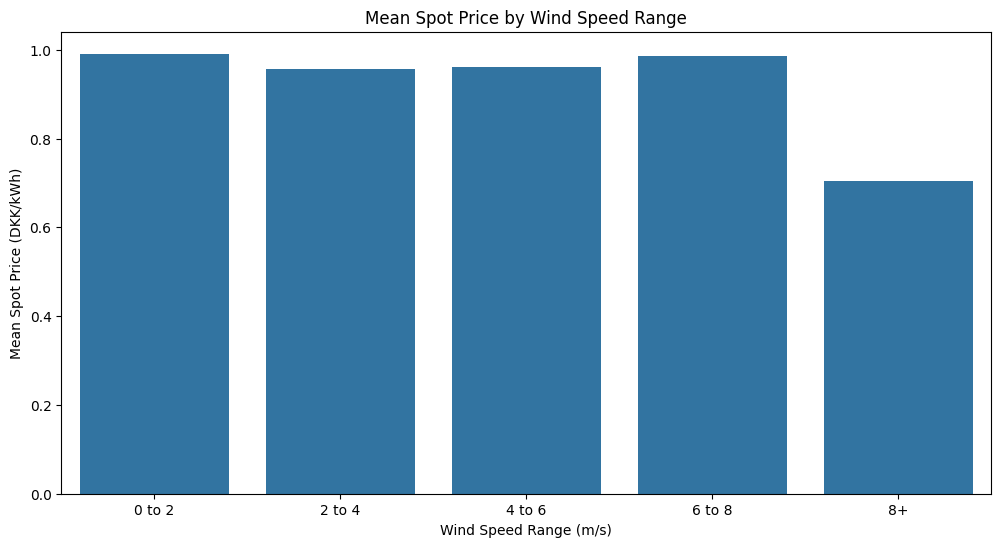

In [49]:
# Define wind speed ranges
wind_speed_ranges = [(0, 2), (2, 4), (4, 6), (6, 8), (8, np.inf)]
wind_speed_labels = ['0 to 2', '2 to 4', '4 to 6', '6 to 8', '8+']

# Categorize wind speed data into ranges
combined_df['wind_speed_range'] = pd.cut(combined_df['wind_speed_10m'], bins=[range[0] for range in wind_speed_ranges] + [np.inf], labels=wind_speed_labels)

# Calculate mean spot price for each wind speed range
mean_spotprice_by_wind_speed = combined_df.groupby('wind_speed_range')['dk1_spotpricedkk_kwh'].mean().reset_index()

# Plot the mean spot price by wind speed range as a histogram
plt.figure(figsize=(12, 6))
sns.barplot(x='wind_speed_range', y='dk1_spotpricedkk_kwh', data=mean_spotprice_by_wind_speed, order=wind_speed_labels)

# Adding labels and title
plt.title('Mean Spot Price by Wind Speed Range')
plt.xlabel('Wind Speed Range (m/s)')
plt.ylabel('Mean Spot Price (DKK/kWh)')

# Show the plot
plt.show()

#### <span style="color:#2656a3;"> 📈 Correlation Matrix
A correlation matrix helps in understanding the strength and direction of the relationship between different variables in the dataset. This is crucial for identifying which variables might influence each other.

In [50]:
# Drop 'timestamp', 'date', and 'datetime' columns
drop_for_corr = combined_df.drop(columns=[ 'timestamp', 
                                           'date',
                                           'datetime', 
                                           'prev_1w_mean', 
                                           'prev_2w_mean', 
                                           'prev_4w_mean', 
                                           'prev_6w_mean', 
                                           'prev_8w_mean', 
                                           'prev_12w_mean', 
                                           'temperature_range', 
                                           'wind_speed_range'
                                           ]
)

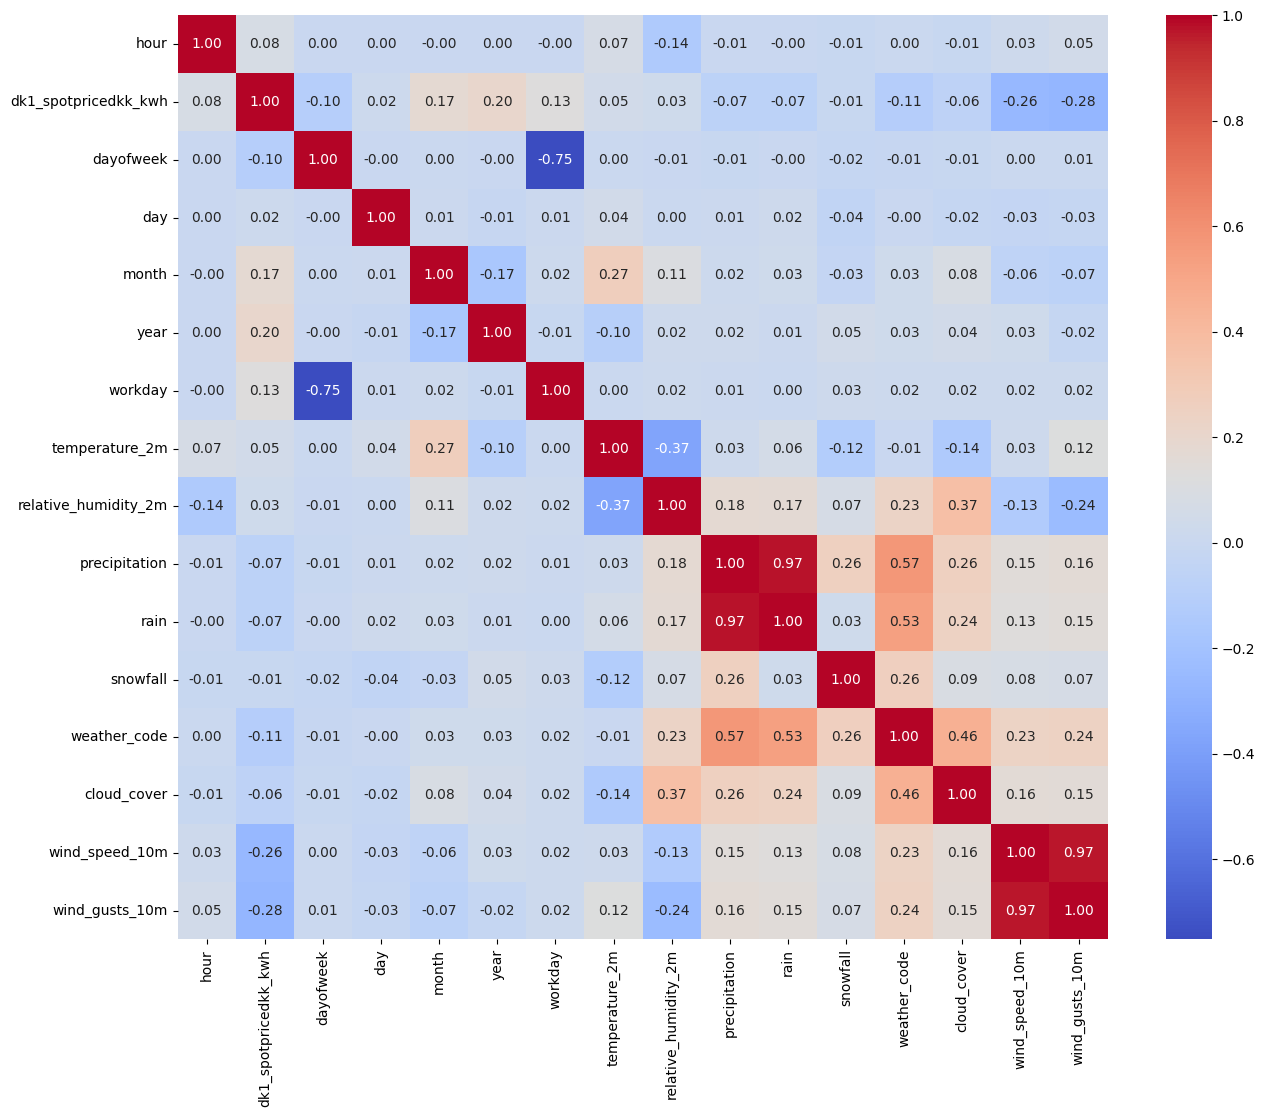

In [51]:
# Create the correlation matrix
correlation_matrix = drop_for_corr.corr()
 
# Set the size of the figure
plt.figure(figsize=(15, 12)) 
 
# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
 
# Display the plot
plt.show()

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store

We connect to Hopsworks Feature Store so we can access and create feature groups.

In [52]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#2656a3;"> 🪄 Creating Feature Groups
A feature group can be seen as a collection of conceptually related features. In this case we create feature groups for the 
- eletricity price data,
- electricity price moving window data,
- weather data,
- calendar data.

We specify a `primary_key` as `date` and `timestamp`, so we are able to join them when we create a dataset for training later in part `3_training_pipeline`.
We define a name and a short describtion of the feature group's contents and a version number. 

`event_time` is specifyed as `timestamp`. If event_time is set the feature group can be used for point-in-time joins.

In [53]:
# Creating the feature group for the electricity prices
electricity_price_fg = fs.get_or_create_feature_group(
    name="electricity_spot_prices",
    version=1,
    description="Electricity spot prices from Energidata API",
    primary_key=["date","timestamp"], 
    event_time="timestamp",
)

We have now outlined metadata for the feature group. Data hasn't been stored yet, and there's no schema defined. To store data persistently for the feature group, we populate it with its associated data using the `insert` function.

In [54]:
# Inserting the electricity_df into the feature group named electricity_fg
electricity_price_fg.insert(electricity_price_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/554133/fs/549956/fg/846205


Uploading Dataframe: 0.00% |          | Rows 0/38539 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: electricity_spot_prices_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/554133/jobs/named/electricity_spot_prices_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x30cc66890>, None)

We make a descriptions for each feature we put into the feature group. In this way we are adding more information and documentation to the user.

In [55]:
# List of descriptions for electricity features
electricity_price_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp of the event time"},
    {"name": "datetime", "description": "Date and time of the electricity measurement"},
    {"name": "date", "description": "Date of the electricity measurement"},
    {"name": "hour", "description": "Hour of the day"},
    {"name": "dk1_spotpricedkk_kwh", "description": "Spot price in DKK per KWH"}, 
]

# Updating feature descriptions
for desc in electricity_price_feature_descriptions: 
    electricity_price_fg.update_feature_description(desc["name"], desc["description"])

We replicate the process for both the `electricity_price_window_fg` and `weather_fg` and `danish_holidays_fg` by establishing feature groups and inserting the dataframes into their respective feature groups.

In [56]:
# Creating the feature group for the electricity price moving window data
electricity_price_window_fg = fs.get_or_create_feature_group(
    name="electricity_spot_price_window",
    version=1,
    description="Moving average of electricity spot prices",
    primary_key=["timestamp"], 
    event_time="timestamp",
)

In [57]:
# Inserting the electricity_window_df into the feature group named electricity_price_window_fg
electricity_price_window_fg.insert(electricity_price_window_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/554133/fs/549956/fg/848214


Uploading Dataframe: 0.00% |          | Rows 0/38544 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: electricity_spot_price_window_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/554133/jobs/named/electricity_spot_price_window_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x16d303b50>, None)

In [58]:
# List of descriptions for electricity features
electricity_price_window_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp for the electricity measurement"},
    {"name": "datetime", "description": "Date and time of the electricity measurement"},
    {"name": "prev_1w_mean", "description": "Avarege electricity price for the previous week"},
    {"name": "prev_2w_mean", "description": "Avarege electricity price for the previous two weeks"},
    {"name": "prev_4w_mean", "description": "Avarege electricity price for the previous four weeks"},
    {"name": "prev_6w_mean", "description": "Avarege electricity price for the previous six weeks"},
    {"name": "prev_8w_mean", "description": "Avarege electricity price for the previous eight weeks"},
    {"name": "prev_12w_mean", "description": "Avarege electricity price for the previous twelve weeks"} 
]

# Updating feature descriptions
for desc in electricity_price_window_feature_descriptions: 
    electricity_price_window_fg.update_feature_description(desc["name"], desc["description"])

In [59]:
# Creating the feature group for the weather data
weather_fg = fs.get_or_create_feature_group(
    name="weather_measurements",
    version=1,
    description="Weather measurements from Open Meteo API",
    primary_key=["date", "timestamp"], 
    event_time="timestamp",
)

In [60]:
# Inserting the weather_df into the feature group named weather_fg
weather_fg.insert(historical_weather_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/554133/fs/549956/fg/847208


Uploading Dataframe: 0.00% |          | Rows 0/38520 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_measurements_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/554133/jobs/named/weather_measurements_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x30cce8e50>, None)

In [61]:
# List of descriptions for weather features
weather_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp for the weather measurement"},
    {"name": "datetime", "description": "Date and time of the weather measurement"},
    {"name": "date", "description": "Date of the weather measurement"},
    {"name": "hour", "description": "Hour of the day"},
    {"name": "temperature_2m", "description": "Temperature at 2m above ground"},
    {"name": "relative_humidity_2m", "description": "Relative humidity at 2m above ground"},
    {"name": "precipitation", "description": "Precipitation"},
    {"name": "rain", "description": "Rain"},
    {"name": "snowfall", "description": "Snowfall"},   
    {"name": "weather_code", "description": "Weather code"},   
    {"name": "cloud_cover", "description": "Cloud cover"},   
    {"name": "wind_speed_10m", "description": "Wind speed at 10m above ground"},   
    {"name": "wind_gusts_10m", "description": "Wind gusts at 10m above ground"},   
]

# Updating feature descriptions
for desc in weather_feature_descriptions: 
    weather_fg.update_feature_description(desc["name"], desc["description"])

In [62]:
# Creating the feature group for the danish calendar
calendar_denmark_fg = fs.get_or_create_feature_group(
    name="calendar_denmark",
    version=1,
    description="Danish calendar with holidays and workdays",
    primary_key=["date"],
)

In [63]:
# Inserting the calendar_df into the feature group named danish_calendar_fg
calendar_denmark_fg.insert(danish_calendar_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/554133/fs/549956/fg/846206


Uploading Dataframe: 0.00% |          | Rows 0/2192 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: calendar_denmark_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/554133/jobs/named/calendar_denmark_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x30c8b5a10>, None)

In [64]:
# List of descriptions for danish_calendar features
calendar_denmark_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp for the calendar event"},
    {"name": "datetime", "description": "Date and time in the calendar"},
    {"name": "date", "description": "Date in the calendar"},
    {"name": "hour", "description": "Hour of the day"},
    {"name": "dayofweek", "description": "Day of the week. Monday is 0 and Sunday is 6"},
    {"name": "day", "description": "Day number of the month"},
    {"name": "month", "description": "Month number of the year"},
    {"name": "year", "description": "Year number"},
    {"name": "workday", "description": "Workday or not a workday. Workday is 1 and not a workday is 0"},
]

# Updating feature descriptions
for desc in calendar_denmark_feature_descriptions: 
    calendar_denmark_fg.update_feature_description(desc["name"], desc["description"])

---
## <span style="color:#2656a3;">⏭️ **Next:** Part 02: Feature Pipeline </span>

Next we will generate new data for the Feature Groups.